In [2]:
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


transfersUnfiltered = pd.read_csv("transfers.csv", sep=";")
clubsInLeaguesDict = pd.read_csv("clubs_in_leagues.csv", sep=";")
clubsDict = pd.read_csv("dict_clubs.csv", sep=";")
countryDict = pd.read_csv("dict_countries.csv", sep=";")
leaguesDict = pd.read_csv("dict_leagues.csv", sep=";")
pos_PlayersDict = pd.read_csv("pos_stats_of_players.csv", sep=";")


first6leagues = list(leaguesDict["country_id"])[:6]

# Filter transfersWithClubs
transfers = transfersUnfiltered[(transfersUnfiltered["is_loan"] == 0) &
                                (transfersUnfiltered["season"] > 2000) &
                                (transfersUnfiltered["fee"] > 0 | ~pd.isnull(transfersUnfiltered["fee"]))]

transfersWithClubs = pd.merge(transfers,clubsDict, left_on="from_club_id", right_on="id")
transfersWithClubs = pd.merge(transfersWithClubs,pos_PlayersDict,left_on="player_id",right_on="id")
transfersWithClubs = transfersWithClubs[transfersWithClubs["country_id"].isin(first6leagues)  ]
headers = transfersWithClubs.columns.tolist()


FileNotFoundError: [Errno 2] No such file or directory: 'transfers.csv'

In [ ]:
unique_vendas = len(transfersUnfiltered[transfersUnfiltered["is_loan"]==0])
unique_Loans =  len(transfersUnfiltered[transfersUnfiltered["is_loan"]==1])
print(f"Número de vendas :{unique_vendas}")
print(f"Número de Empréstimos :{unique_Loans}")


Número de vendas :94312
Número de Empréstimos :17290


In [ ]:
TopClubSet = transfersWithClubs.groupby(["from_club_name", "country_id"])["fee"].sum()
TopClubSet = pd.DataFrame(TopClubSet)
TopClubSet = TopClubSet.sort_values(by="fee", ascending=False)
TopClubSet = TopClubSet.reset_index()
TopClubs =[]

In [ ]:
for country in TopClubSet["country_id"].unique():
     TopClubs += TopClubSet[TopClubSet["country_id"]==country].nlargest(2000,"fee")["from_club_name"].to_list()



In [ ]:
transfersWithClubs = transfersWithClubs[transfersWithClubs["from_club_name"].isin(TopClubs) & transfersWithClubs["to_club_name"].isin(TopClubs) ]

transfersWithClubs['fee'] = transfersWithClubs['fee'].astype(float)


# Create edges as tuples with weight as an attribute
edges = [(row['from_club_name'], row['to_club_name'],row['fee']) for _, row in transfersWithClubs.iterrows()]



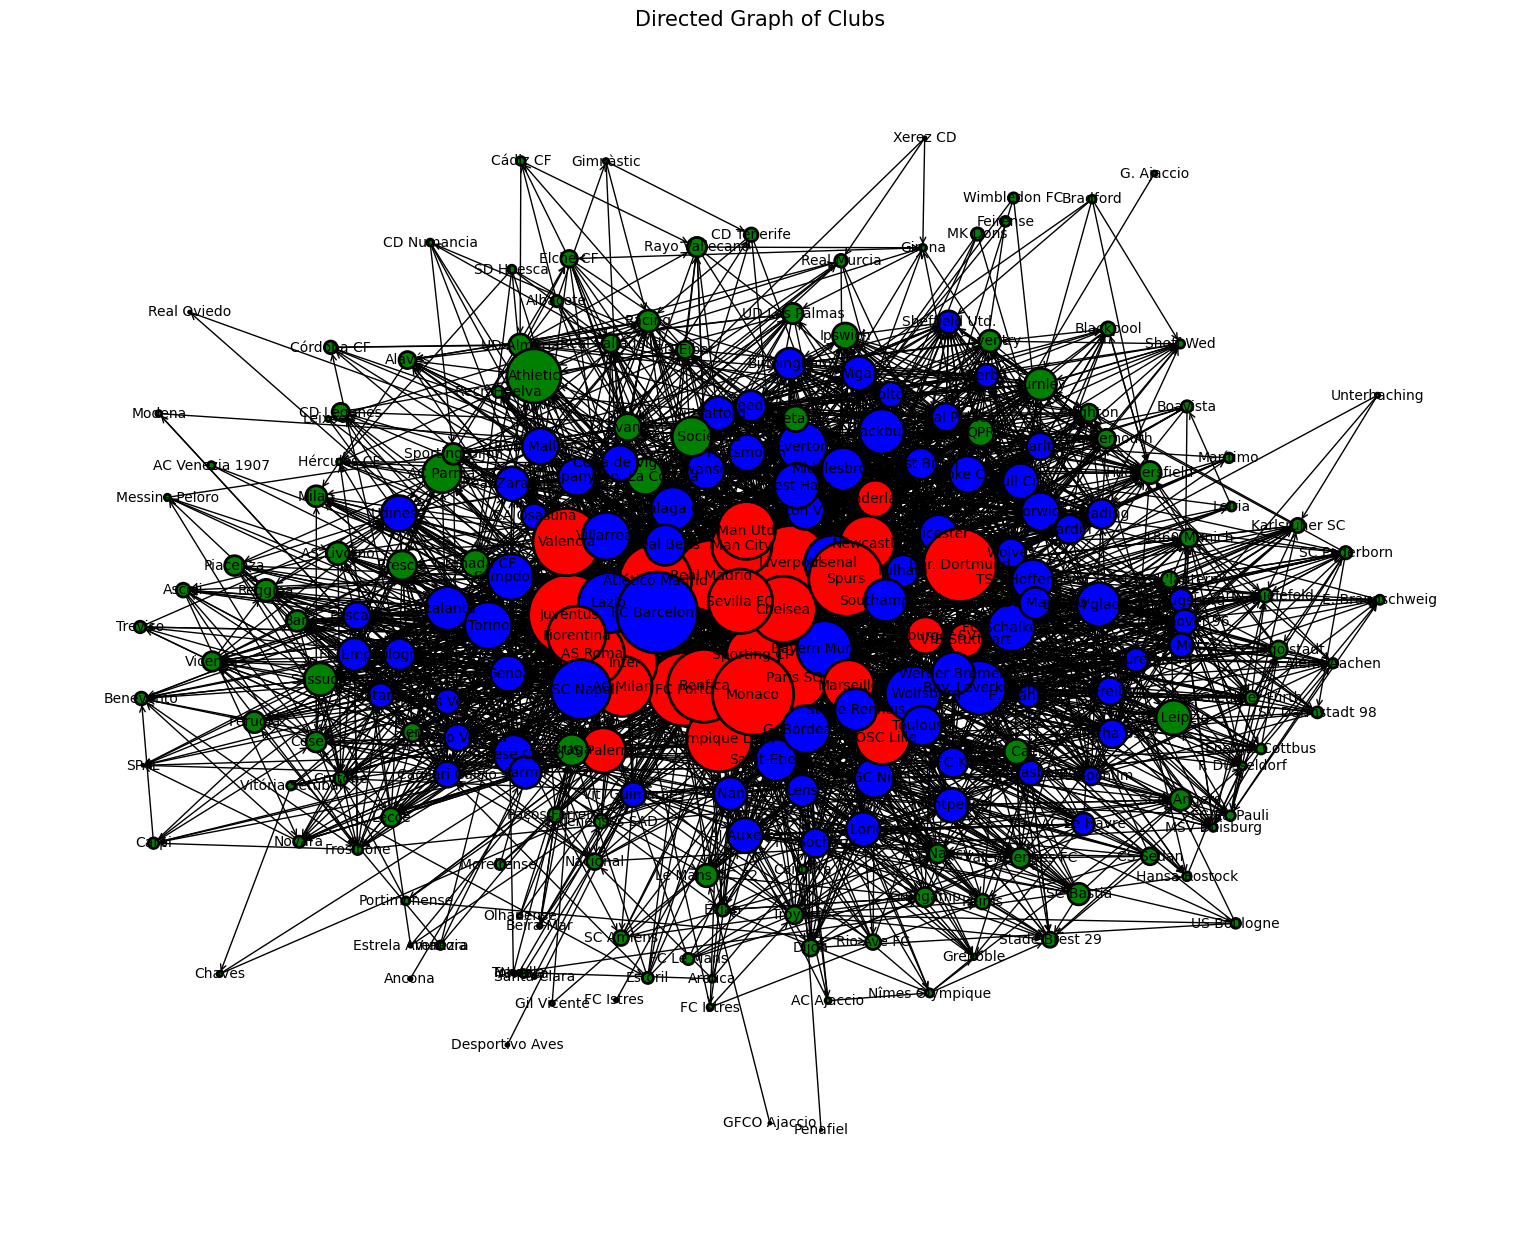

In [ ]:

# Create directed graph
G = nx.DiGraph()
G.add_weighted_edges_from(edges)
node_weights = {node: 0 for node in G.nodes()}




for node in G.nodes():
    node_weight = sum(data['weight'] for _, _, data in G.edges(node, data=True))
    node_weights[node] = node_weight
    G.nodes[node]['weight'] = node_weight
    G.nodes[node]['country'] = (
    clubsDict[clubsDict["name"] == node]["country_id"].values[0]
    if not clubsDict[clubsDict["name"] == node]["country_id"].values.size == 0
    else '')

countries = TopClubSet["country_id"].unique()
colors = ["red", "blue", "green"]

degrees = dict(G.out_degree())

max_degree = max(degrees.values())
low_threshold = max_degree / 3
high_threshold = 2 * max_degree / 3


# Assign nodes to groups based on their degree
for node, degree in degrees.items():

    if degree <= low_threshold:
        G.nodes[node]['color'] = "green"  # Low degree
    elif degree <= high_threshold:
        G.nodes[node]['color'] =  "blue" # Medium degree
    else:
        G.nodes[node]['color'] = "red" # High degree




node_colors = [attrs['color'] for _, attrs in G.nodes(data=True)]
node_sizes = [(node_weights[node]/150000) for node in G.nodes()]


plt.figure(figsize=(15, 12))
layout = nx.kamada_kawai_layout(G, weight='fee')
nx.draw(G, layout, with_labels=True, node_color=node_colors, node_size=node_sizes, font_size=10, edgecolors='black',  linewidths=2,  font_weight='normal', arrowstyle='->', arrowsize=10)
plt.title('Directed Graph of Clubs', fontsize=15)
plt.show()



In [ ]:
print(f"Is the network strongly connected? \nR:{nx.is_strongly_connected(G)}")

largest_scc = max(nx.strongly_connected_components(G), key=len)
subgraph = G.subgraph(largest_scc)

# Calculate diameter of the largest SCC
diameter = nx.diameter(subgraph)
print(f"Diameter of the largest strongly connected component: {diameter}")

Is the network strongly connected? 
R:False
Diameter of the largest strongly connected component: 5


In [ ]:
degree_assortativity = nx.degree_assortativity_coefficient(G)
nominal_assortativity = nx.attribute_assortativity_coefficient(G,'color')
numeric_assortativity = nx.numeric_assortativity_coefficient(G,'weight')
nominal_assortativityCountry = nx.attribute_assortativity_coefficient(G,'country')
print(f"Degree Assortativity Coefficient: {degree_assortativity:.3f}")
print(f"Degree group Assortativity Coefficient: {nominal_assortativity:.3f}")
print(f"Fee Assortativity Coefficient: {numeric_assortativity:.3f}")
print(f"country Assortativity Coefficient: {nominal_assortativityCountry:.3f}")



Degree Assortativity Coefficient: 0.140
Degree group Assortativity Coefficient: 0.068
Fee Assortativity Coefficient: 0.165
country Assortativity Coefficient: 0.560


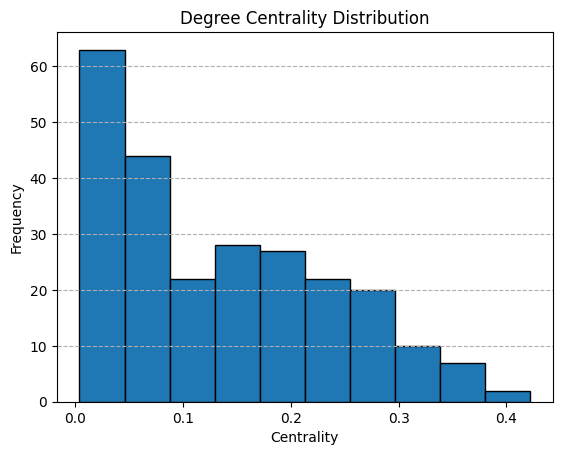

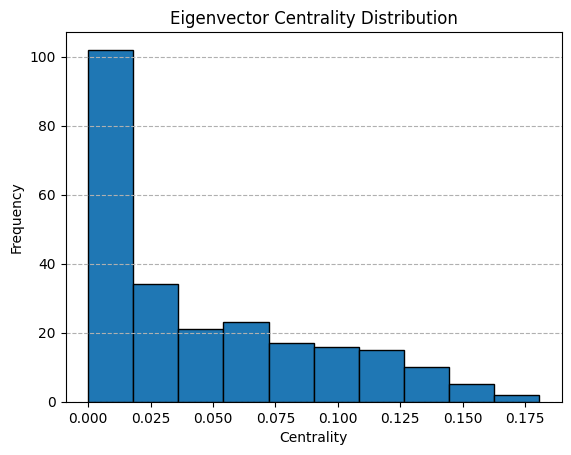

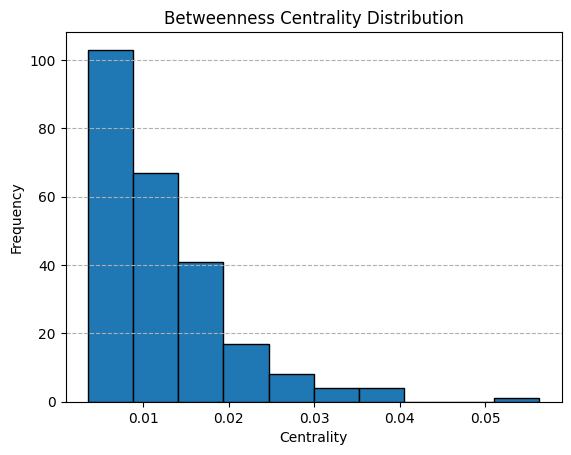

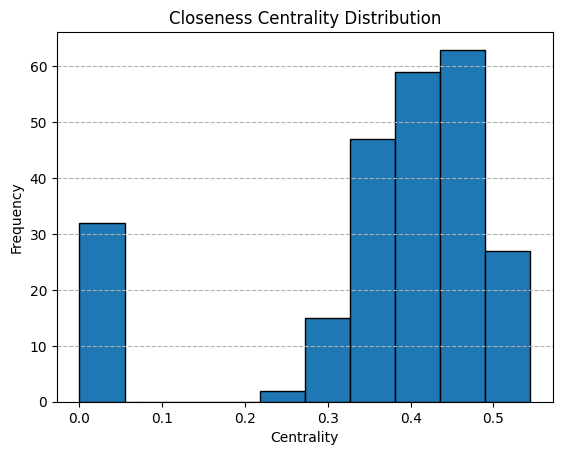

In [ ]:
# Calculate the centralities
import operator


degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, endpoints=True)
closeness_centrality = nx.closeness_centrality(G)


# Function to plot the centrality distributions
def plot_centrality_distribution(centrality_dict, title):
    plt.figure()
    plt.hist(list(centrality_dict.values()), bins=10, edgecolor='black')
    plt.xlabel('Centrality')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(axis='y', linestyle='--')
    plt.show()

# Plot each centrality distribution
plot_centrality_distribution(degree_centrality, "Degree Centrality Distribution")
plot_centrality_distribution(eigenvector_centrality, "Eigenvector Centrality Distribution")
plot_centrality_distribution(betweenness_centrality, "Betweenness Centrality Distribution")
plot_centrality_distribution(closeness_centrality, "Closeness Centrality Distribution")


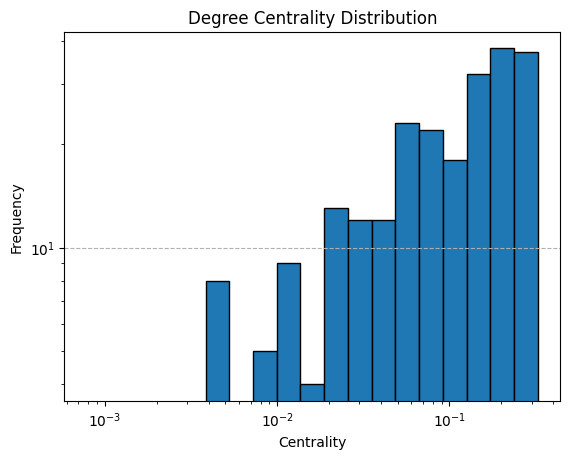

In [ ]:
# Function to plot the centrality distributions
def plot_centrality_distribution(centrality_dict, title):
    data = list(centrality_dict.values()) 
    plt.figure()
    start, stop = np.log10(min(data)), np.log10(max(data))
    bins = 20 ** np.linspace(start, stop, 20)
    plt.hist(data, log=True, bins=bins, edgecolor='black')
    plt.xscale('log')
    plt.xlabel('Centrality')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(axis='y', linestyle='--')
    plt.show()

# Plot each centrality distribution
plot_centrality_distribution(degree_centrality, "Degree Centrality Distribution")

In [ ]:
from itertools import combinations
from networkx.algorithms.community import girvan_newman

def matriz_sobreposicao(G):
    nodes = list(G.nodes())
    n = len(nodes)
    X = np.zeros((n, n))
    for i, j in combinations(range(n), 2):
        # Get neighbors of i and j
        Vi = set(G.neighbors(nodes[i]))
        Vj = set(G.neighbors(nodes[j]))
        vizinhos_comuns = len(Vi.intersection(Vj))
        if G.has_edge(nodes[i], nodes[j]): vizinhos_comuns += 1
        min_kij = min(len(Vi), len(Vj))
        if min_kij > 0:
            X[i, j] = vizinhos_comuns / min_kij
            X[j, i] = X[i, j]        
    return X

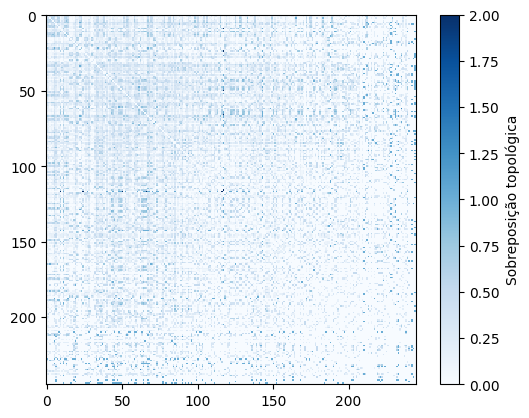

In [ ]:
matriz_similaridade = matriz_sobreposicao(G)
plt.imshow(matriz_similaridade, cmap='Blues', interpolation='none')
plt.colorbar(label='Sobreposição topológica')

In [ ]:
def comunidades_girvan_newman(g, profundidade=5):
    componentes = girvan_newman(g)
    limite = tuple(sorted(c) for c in next(componentes))
    for i in range(1, profundidade):
        limite = tuple(sorted(c) for c in next(componentes))
    return limite
comunidades = comunidades_girvan_newman(G, profundidade=5)
comunidades

(['1. FC Köln',
  "1.FC K'lautern",
  '1.FC Nuremberg',
  '1.FSV Mainz 05',
  '1860 Munich',
  'AC Ajaccio',
  'AC Le Havre',
  'AC Milan',
  'AC Parma',
  'AC Venezia 1907',
  'AJ Auxerre',
  'AS Livorno',
  'AS Nancy',
  'AS Roma',
  'Alavés',
  'Albacete',
  'Alem. Aachen',
  'Ancona',
  'Arm. Bielefeld',
  'Arouca',
  'Arsenal',
  'Ascoli',
  'Aston Villa',
  'Atalanta',
  'Athletic',
  'Atlético Madrid',
  'Bari',
  'Bay. Leverkusen',
  'Bayern Munich ',
  'Beira-Mar',
  'Belenenses SAD',
  'Benevento',
  'Benfica',
  'Birmingham',
  'Blackburn',
  'Blackpool',
  'Boavista',
  'Bologna',
  'Bolton',
  'Bor. Dortmund',
  "Bor. M'gladbach",
  'Bournemouth',
  'Bradford',
  'Braga',
  'Brescia',
  'Brighton',
  'Burnley',
  'CA Osasuna',
  'CD Leganés',
  'CD Numancia',
  'CD Tenerife',
  'CS Sedan',
  'Cagliari Calcio',
  'Cardiff',
  'Carpi',
  'Catania',
  'Celta de Vigo',
  'Cesena',
  'Charlton',
  'Chaves',
  'Chelsea',
  'Chievo Verona',
  'Coimbra',
  'Coventry',
  'Crotone',

['lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue'

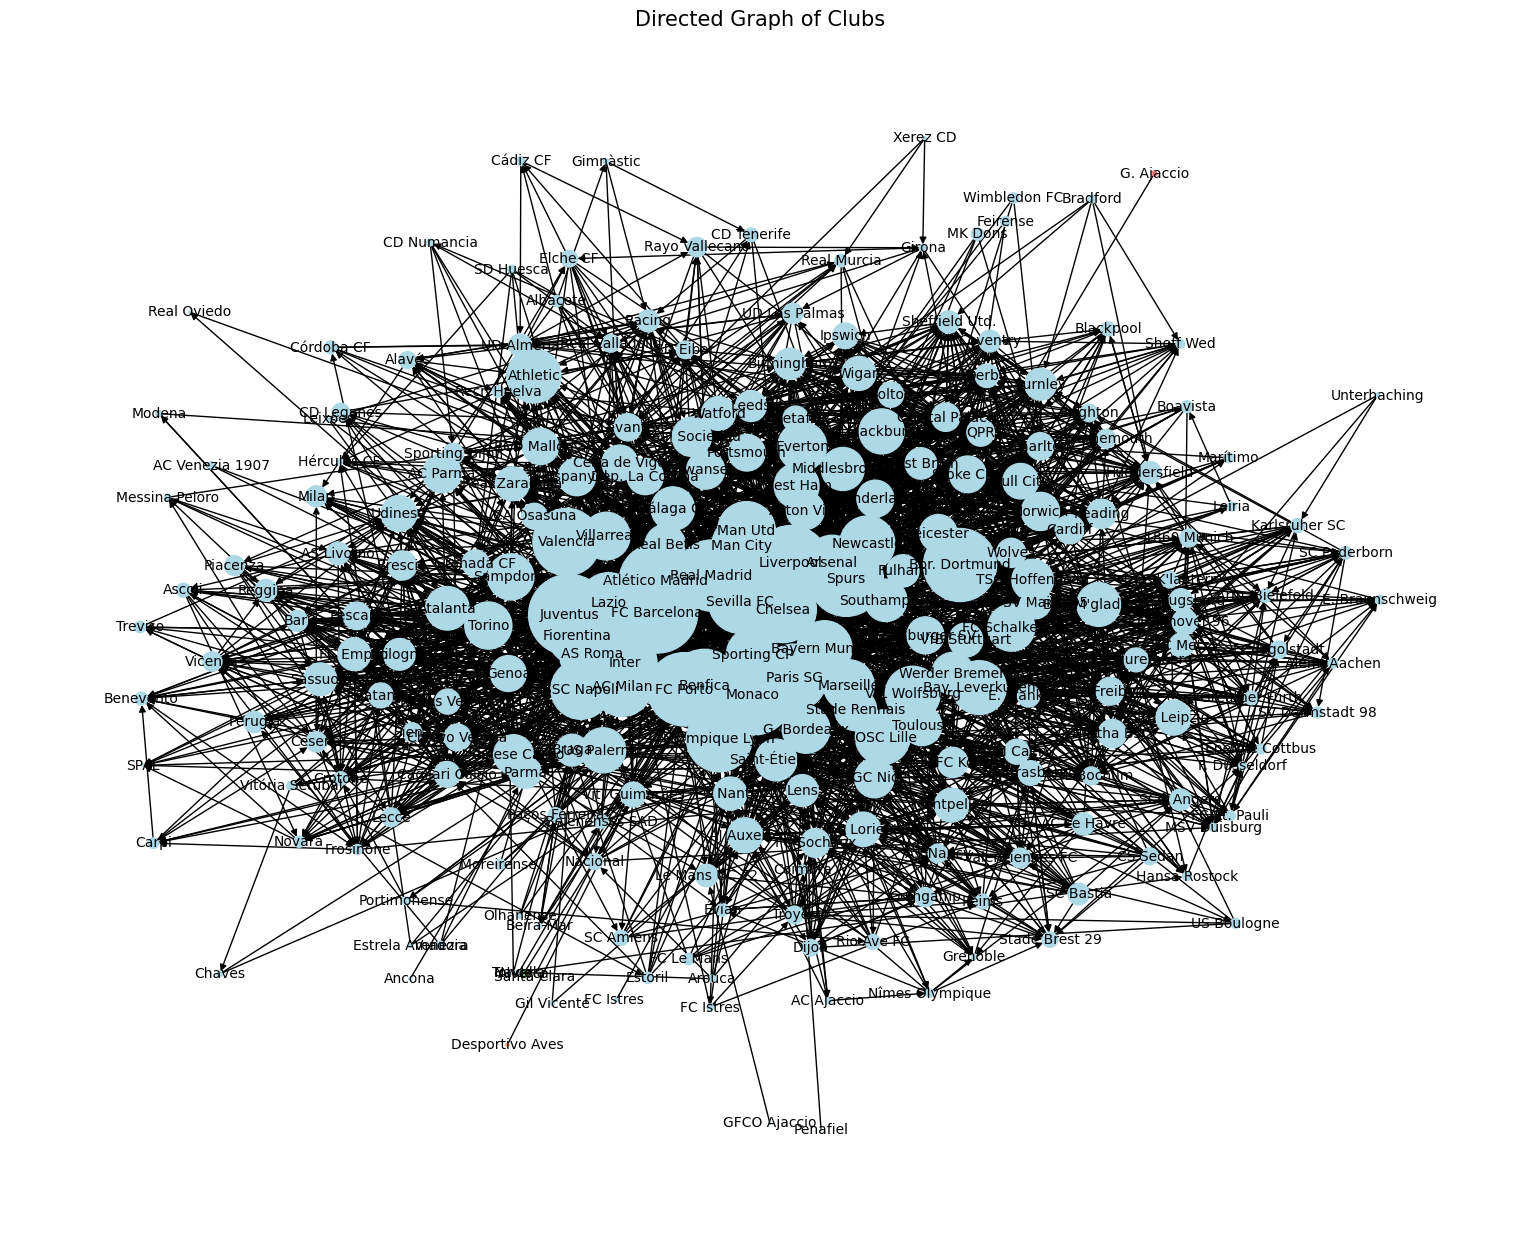

In [ ]:
cores = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightsalmon']
mapa_cores = []
for no in G.nodes():
    for idx, comunidade in enumerate(comunidades):
        if no in comunidade: mapa_cores.append(cores[idx % len(cores)])
print(mapa_cores)
plt.figure(figsize=(15, 12))
layout = nx.kamada_kawai_layout(G, weight='fee')  
nx.draw(G, layout, with_labels=True, node_color=mapa_cores, node_size=node_sizes, font_size=10)
plt.title('Directed Graph of Clubs', fontsize=15)
plt.show()